In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import h5py
import corner

import sys
sys.path.append('../python/')
from edw_data_util import *

GGA3/NR/4.0/5.556E-02/0.0380/000/0.1493/0.1782/0.9975/
GGA3/NR/4.0/5.556E-02/0.0381/000/0.1537/0.1703/0.9948/


In [2]:
filename = 'data/edelweiss_corr1_systematicErrors_sampler_nll_allpars_corrAB_gausPrior_2844a28.h5'

In [3]:
f = h5py.File(filename,'r')

# need to store data in an array:
# The sampler will now have a chains attribute 
# which is an array with shape (Nwalker,N,Ndim) 
# where N is the number of interations (500 in our inital run)
# and Ndim is the number of fit parameters
path='{}/{}/'.format('mcmc','sampler')

aH = np.asarray(f[path+'aH'])
C = np.asarray(f[path+'C'])
m = np.asarray(f[path+'m'])
scale = np.asarray(f[path+'scale'])
A = np.asarray(f[path+'A'])
B = np.asarray(f[path+'B'])
samples = np.asarray(f[path+'samples'])

f.close()

In [4]:
print (np.shape(samples))
print (samples[:,:,1])
aH_interval = hpd(np.ndarray.flatten(samples[:,:,0]), 0.6827)
print (aH_interval)

(100, 5000, 6)
[[0.03383839 0.03422393 0.03422393 ... 0.03305807 0.03305807 0.03305807]
 [0.03523041 0.03665635 0.03665635 ... 0.03565165 0.03394058 0.03491631]
 [0.03136095 0.0314244  0.0314244  ... 0.0363116  0.0363116  0.03627199]
 ...
 [0.03449717 0.03260372 0.03260372 ... 0.03084531 0.02891799 0.02989469]
 [0.03540461 0.03540461 0.03559485 ... 0.02874892 0.02874892 0.02783924]
 [0.02946945 0.02946945 0.02946945 ... 0.03005696 0.03008158 0.03008158]]
[0.03634714 0.03950225]


In [41]:
ndim = 6
samples_corner = samples[:, 300:, :].reshape((-1, ndim))

sampsize=100
Erecoil_keV = np.linspace(10, 200, 50)
evec = np.zeros((np.size(Erecoil_keV),sampsize))

print(np.shape(samples[np.random.randint(len(samples), size=sampsize)]))

for i, (aH, C, m, scale, A, B) in enumerate(samples_corner[np.random.randint(len(samples_corner), size=sampsize)]):
    if aH >= aH_interval[0] and aH <= aH_interval[1]:
        V = scale*4.0
        model_NR_0 = [series_NRQ_var_corr2(x, 0, V, aH, 1/18.0, A, B, 'GGA3') for x in Erecoil_keV] 
        model_NR = np.sqrt(np.power(C + m*Erecoil_keV, 2) + model_NR_0)

        v = model_NR
        #print(np.std(v))
        #print(np.mean(v))
        evec[:,i] = v

## calculate the best-fit values
aH_fit, C_fit, m_fit, scale_fit = 3.81134613e-02, 3.32613445e-02, 1.11522962e-04, 9.94778557e-01
A_fit, B_fit = 1.53737587e-01, 1.70327657e-01 
V_fit = 4*scale_fit

model_NR_0 = [series_NRQ_var_corr1(x, 0, V_fit, aH_fit, 1/18.0, A_fit, B_fit, 'GGA3') for x in Erecoil_keV] 
model_NR_fit = np.sqrt(np.power(C_fit + m_fit*Erecoil_keV, 2) + model_NR_0)

(100, 5000, 6)


(50, 100)


(10, 200)

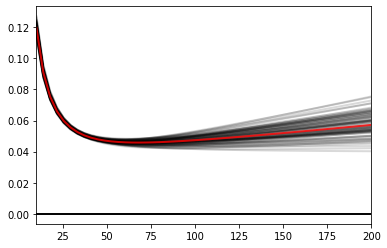

In [6]:
print(np.shape(evec))
for model_NR in np.transpose(evec):
    plt.plot(Erecoil_keV, model_NR, color="k", lw=2, alpha=0.15)
    
plt.plot(Erecoil_keV, model_NR_fit, color="r", lw=2, alpha=0.8)

plt.xlim(10, 200)
#plt.ylim(0.04, 0.1)

# What is up with the zeros???

## Okay, trying something new
Compare the best-fit yield variance (using sigmom) with the yield variance using the maxima of the posterior distribution 

In [34]:
hist_aH, bins_aH = np.histogram(np.ndarray.flatten(samples[:,:,5]),bins=30)

max_idx_aH = np.argmax(hist_aH)
mcmc_aH = 0.5*(bins_aH[max_idx_aH] + bins_aH[max_idx_aH+1])
print (0.5*(bins_aH[max_idx_aH] + bins_aH[max_idx_aH+1]))

0.1760836791358892


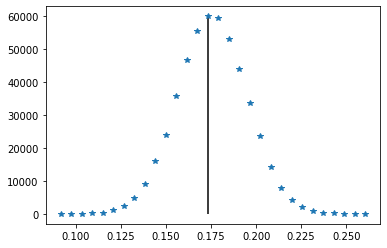

In [35]:
plt.plot(bins_aH[:-1], hist_aH, '*')
plt.vlines(bins_aH[max_idx_aH], 0, 60000)

In [23]:
# aH, C, m, scale, A, B correspond to indices
# 0, 1, 2, 3, 4, 5
mcmc_par_arr = []
print (mcmc_par_arr)
for idx in range(0,6):
    hist_par, bins_par = np.histogram(np.ndarray.flatten(samples[:,:,idx]),bins=30)
    max_idx_par = np.argmax(hist_par)
    mcmc_par = 0.5*(bins_par[max_idx_par] + bins_par[max_idx_par+1])
    print(idx, mcmc_par)
    
    mcmc_par_arr.append(mcmc_par)
    
print (mcmc_par_arr)

[]
0 0.038054209883418
1 0.032639352257662665
2 0.00011534931468228008
3 1.0032696207183334
4 0.1479094750785308
5 0.1760836791358892
[0.038054209883418, 0.032639352257662665, 0.00011534931468228008, 1.0032696207183334, 0.1479094750785308, 0.1760836791358892]


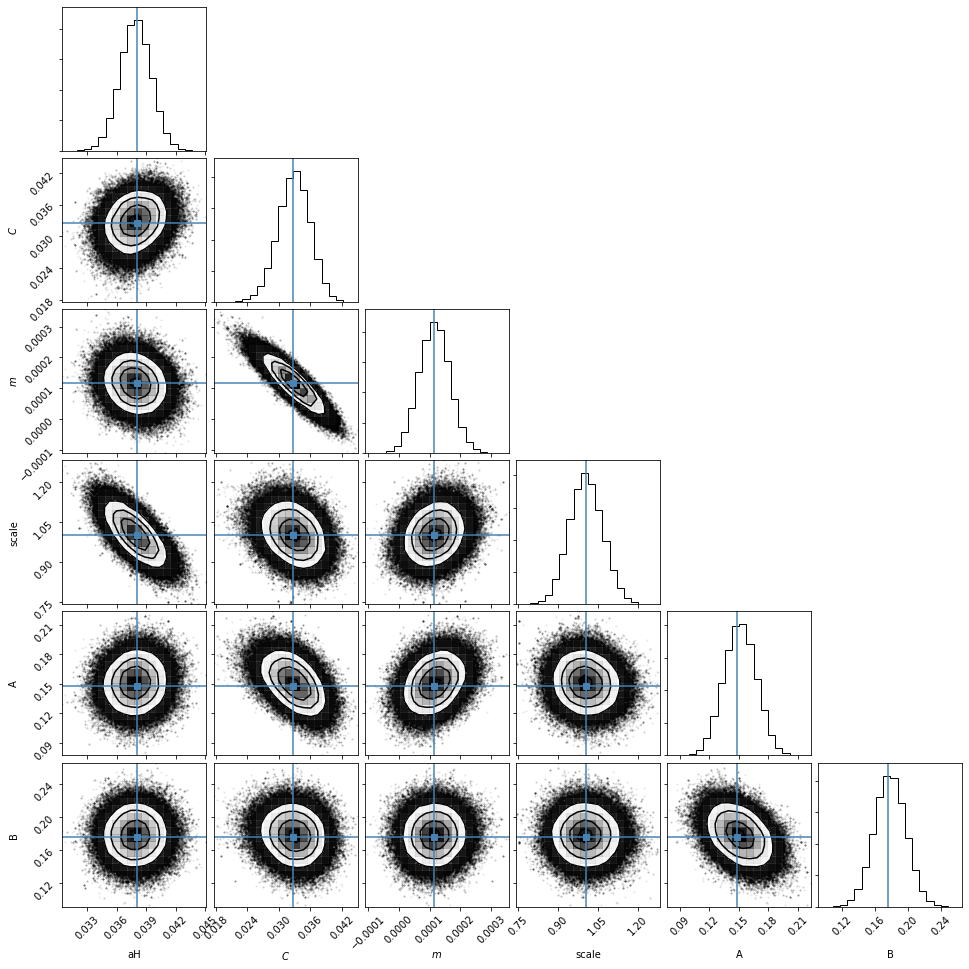

In [24]:
fig = corner.corner(samples_corner, labels=["aH", "$C$", "$m$", "scale", "A", "B"],
                      truths=mcmc_par_arr)

(10, 200)

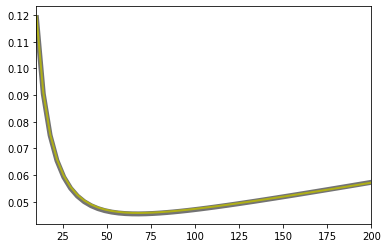

In [43]:
# set the max mcmc values
aH_mcmc, C_mcmc, m_mcmc, scale_mcmc, A_mcmc, B_mcmc = mcmc_par_arr
V_mcmc = 4*scale_mcmc

model_NR_0_mcmc = [series_NRQ_var_corr1(x, 0, V_mcmc, aH_mcmc, 1/18.0, A_mcmc, B_mcmc, 'GGA3') for x in Erecoil_keV] 
model_NR_mcmc = np.sqrt(np.power(C_mcmc + m_mcmc*Erecoil_keV, 2) + model_NR_0_mcmc)

plt.plot(Erecoil_keV, model_NR_mcmc, color="k", lw=5, alpha=0.55)
plt.plot(Erecoil_keV, model_NR_fit, color="y", lw=2, alpha=0.8)

plt.xlim(10, 200)
#plt.ylim(0.04, 0.1)